In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score,LeaveOneOut
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report,confusion_matrix,f1_score,roc_curve,roc_auc_score,precision_recall_curve,auc

## Feature engineering

Irá ser feito a criação das seguintes features:

- age*trestbps : A pressão arterial sistólica em idosos tende a ser mais preocupante; então, ao multiplicar idade por pressão, estamos dando mais peso para valores altos em pacientes idosos.

- chol ÷ age : colesterol tende a aumentar com a idade, então esse ajuste relativo mostra se o colesterol está alto para a idade. Um jovem com colesterol 230 é diferente de um idoso com 230.

- thalach - age : thalach (frequência cardíaca máxima) normalmente diminui com a idade. Um valor muito alto em idosos pode ser arriscado ou sinal de teste mal executado.

## Considerações sobre as categorias:

- Nas variáveis sex,cp,fbs,restcg,exang,thal serão aplicados o One-Hot enconding.
- Variável slope será utilizado o ordinal encondings, para preservar esse comportamento de proximidade.

In [80]:
# Abrindo os dados
df = pd.read_csv("../dataset/Heart_Attack_Data_Set.csv")
# Escolhendo essa paleta de cores
sns.set_palette("muted")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [81]:
# Separando as colunas e cada tipo
categorical_features = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
numerical_features = df.drop(columns=categorical_features + ['target']).columns

In [82]:
X = df.drop(columns=['target'])
y = df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
df_train = pd.concat([X_train,y_train],axis=1)

In [83]:
ordinal_enconding = ['slope']
one_hot_enconding = ['sex','cp','fbs','restecg','exang','thal']

## Considerações sobre as variáveis numéricas:
- Vamos usar o standard scaler para escalonar nossos dados, pois alguns algoritmos são sensíveis a faixa de valores diferentes entre as features.

In [84]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df['age_trestbps'] = df['age'] * df['trestbps']
        df['chol_per_age'] = df['chol'] / df['age']
        df['thalach_minus_age'] = df['thalach'] - df['age'] 
        return df


In [85]:
from sklearn.preprocessing import OneHotEncoder
linear_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()), 
    ('column_transform', ColumnTransformer(
        transformers=[
            ('one_hot_encoder', OneHotEncoder(), one_hot_enconding),
            ('ordinal_encoder', OrdinalEncoder(), ordinal_enconding),
            ('std_scaler',StandardScaler(),numerical_features)
        ],
        remainder="passthrough"
    ))
])

In [86]:
X_train_prepared_linear = linear_pipeline.fit_transform(X_train,y_train)
X_train_prepared_linear.shape

(242, 27)

In [87]:
from category_encoders import TargetEncoder

tree_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineer()),   
    ('column_transform', ColumnTransformer(
        transformers=[
            ('target_encoder', TargetEncoder(), one_hot_enconding),
            ('ordinal_encoder', OrdinalEncoder(), ordinal_enconding),
        ],
        remainder="passthrough"
    ))
])

In [88]:
X_train_prepared_tree = tree_pipeline.fit_transform(X_train,y_train)
X_train_prepared_tree.shape

(242, 16)

In [89]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
linear_models = {
                'Linear_SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                'Logistic_Regression': LogisticRegression(max_iter=10000),
                }

tree_models = {
              'Decision_Tree': DecisionTreeClassifier(),
              'Random_Forest': RandomForestClassifier(),
              }

In [90]:
from sklearn.model_selection import cross_val_score,LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

loo = LeaveOneOut()
model_cross_val = {}
model_train_val = {}

for name, model in linear_models.items():

    model.fit(X_train_prepared_linear,y_train)
    y_pred = model.predict(X_train_prepared_linear)
    f1 = f1_score(y_train,y_pred)


    scores = cross_val_score(model,X_train_prepared_linear, y_train, cv=20, scoring='f1')
    avg_cross_val = np.mean(scores)
    std_deviation = np.std(scores)
    
    model_train_val[name] = f1
    model_cross_val[name] = avg_cross_val

    print(f"Modelo : {name}\n Média do f1 score na validaçao cruzada {avg_cross_val} ± {std_deviation}\n Valor do f1 score nos dados de treino: {f1}")
    print(80*"=")


Modelo : Linear_SVC
 Média do f1 score na validaçao cruzada 0.8596958678576325 ± 0.08333464972748911
 Valor do f1 score nos dados de treino: 0.8717948717948718
Modelo : KNN
 Média do f1 score na validaçao cruzada 0.5938240191181368 ± 0.13615886406739947
 Valor do f1 score nos dados de treino: 0.7887323943661971
Modelo : Logistic_Regression
 Média do f1 score na validaçao cruzada 0.8629696773814421 ± 0.08499239161354318
 Valor do f1 score nos dados de treino: 0.875


In [91]:
df_cross_val = pd.DataFrame(list(model_cross_val.items()), columns=['model', 'avg_val_score'])
df_train = pd.DataFrame(list(model_train_val.items()), columns=['model', 'train_score'])

df_eval = pd.merge(df_train,df_cross_val,on='model',sort=True).reset_index(drop=True)
df_eval

,model,train_score,avg_val_score
0,KNN,0.788732,0.593824
1,Linear_SVC,0.871795,0.859696
2,Logistic_Regression,0.875000,0.862970


In [92]:
df_melted = df_eval.melt(id_vars='model', var_name='Score_Type', value_name='Score')
df_melted

,model,Score_Type,Score
0,KNN,train_score,0.788732
1,Linear_SVC,train_score,0.871795
2,Logistic_Regression,train_score,0.875000
3,KNN,avg_val_score,0.593824
4,Linear_SVC,avg_val_score,0.859696
5,Logistic_Regression,avg_val_score,0.862970


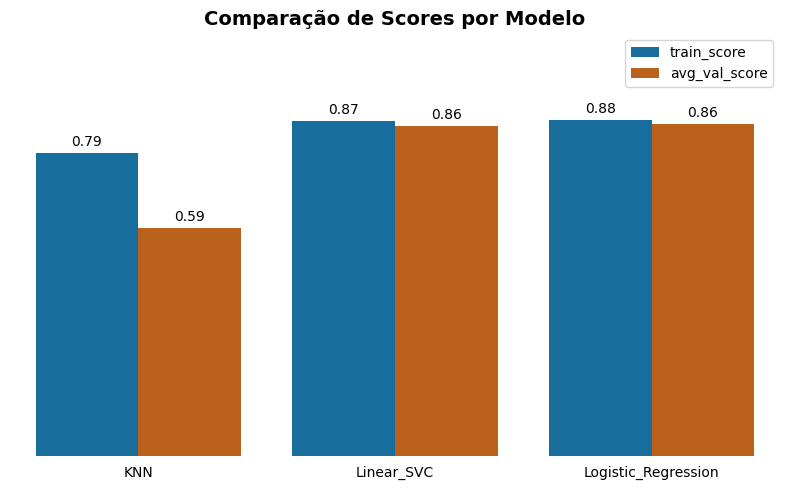

In [93]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_melted, x='model', y='Score', hue='Score_Type',palette = ['#0173B2','#D55E00'])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

# Remove os eixos (ticks e spines)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Comparação de Scores por Modelo', fontsize=14, weight='bold')
ax.set_ylim(0, 1.1)
ax.legend(title='')

# Remove as linhas dos eixos
sns.despine(left=True, bottom=True)
ax.tick_params(left=False, bottom=False)
ax.set_yticks([])

plt.tight_layout()
plt.show()

In [94]:

from sklearn.model_selection import cross_val_score,LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
loo = LeaveOneOut()

model_cross_val = {}
model_train_val = {}

for name, model in tree_models.items():
    
    model.fit(X_train_prepared_tree,y_train)
    y_pred = model.predict(X_train_prepared_tree)
    f1 = f1_score(y_train,y_pred)

    scores = cross_val_score(model,X_train_prepared_linear, y_train, cv=20, scoring='f1')
    avg_cross_val = np.mean(scores)
    std_deviation = np.std(scores)
    
    model_train_val[name] = f1
    model_cross_val[name] = avg_cross_val

    print(f"Modelo : {name}\n Média do f1 score na validaçao cruzada {avg_cross_val} ± {std_deviation}\n Valor do f1 score nos dados de teste: {f1}")


Modelo : Decision_Tree
 Média do f1 score na validaçao cruzada 0.7110726854844502 ± 0.13170829395487596
 Valor do f1 score nos dados de teste: 1.0
Modelo : Random_Forest
 Média do f1 score na validaçao cruzada 0.8456206048853108 ± 0.08800729035907631
 Valor do f1 score nos dados de teste: 1.0


In [95]:
df_cross_val = pd.DataFrame(list(model_cross_val.items()), columns=['model', 'avg_val_score'])
df_train = pd.DataFrame(list(model_train_val.items()), columns=['model', 'train_score'])

df_eval = pd.merge(df_train,df_cross_val,on='model',sort=True).reset_index(drop=True)
df_eval

,model,train_score,avg_val_score
0,Decision_Tree,1.0,0.711073
1,Random_Forest,1.0,0.845621


In [96]:
df_melted = df_eval.melt(id_vars='model', var_name='Score_Type', value_name='Score')

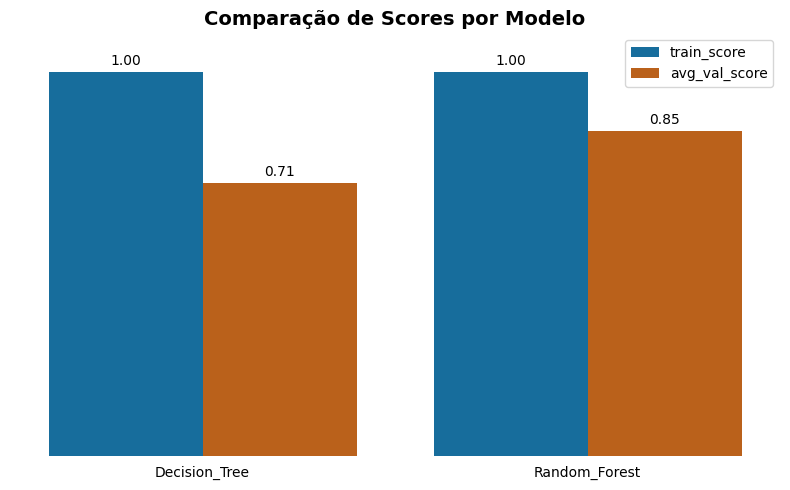

In [97]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_melted, x='model', y='Score', hue='Score_Type',palette = ['#0173B2','#D55E00'])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

# Remove os eixos (ticks e spines)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Comparação de Scores por Modelo', fontsize=14, weight='bold')
ax.set_ylim(0, 1.1)
ax.legend(title='')

# Remove as linhas dos eixos
sns.despine(left=True, bottom=True)
ax.tick_params(left=False, bottom=False)
ax.set_yticks([])

plt.tight_layout()
plt.show()

## Considerações

Os resultados aparentam ser razoáveis, parece haver um overfitting nos modelos baseados em árvores no dados de treinamento, o KNN parece que se saiu pior, a regressão logística e o linear SVC se saíram melhor. Para a seleção de features e fine-tune do modelo eu ficarei com a regressão logística, apesar de nesse resultado o modelo SVC ter se saído um pouco melhor. Vamos ver se esse modelo conseguirá algum tipo de melhoria com a otimização dos seus hiperparametros.

## Seleção de features

Nesse caso como utilizarei a regressão logística não utilizarei técnicas como Recursive Feature Elimination para diminuir as features, por conta da própria capacidade de regularização do modelo. Com a penalidade L1, adicionará um termo de regularização que força alguns coeficientes a se tornarem exatamente zero, o que já vai eliminar algumas features menos importantes automaticamente. Enquanto que a penalidade L2, ela não vai zerar os coeficientes, mas vai reduzir sua magnitude.
Recursive Feature Elimination (RFE) é uma técnica de seleção de variáveis que visa identificar as features mais relevantes para um modelo preditivo. Ela funciona de forma recursiva: treina o modelo, avalia a importância de cada variável (com base em coeficientes ou importância de features), elimina a menos relevante e repete o processo até restar um número desejado de variáveis. Essa abordagem é especialmente útil para reduzir dimensionalidade, melhorar a generalização do modelo e aumentar a interpretabilidade, mantendo apenas os atributos mais impactantes na previsão. Eu irei utilizar o RFECV para ele encontrar o número ideal de features.

In [98]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

model = LogisticRegression(max_iter=10000)
cv = StratifiedKFold(n_splits=20)

selector = RFECV(estimator=model, step=1, cv=cv, scoring='f1')
selector.fit(X_train_prepared_linear, y_train)

col_transformer = linear_pipeline.named_steps['column_transform']
feature_names = col_transformer.get_feature_names_out()

# Filtra apenas as selecionadas
selected_features = feature_names[selector.support_]
print(f" tamanho {len(selected_features)} features {selected_features}")

 tamanho 15 features ['one_hot_encoder__sex_0' 'one_hot_encoder__sex_1' 'one_hot_encoder__cp_0'
 'one_hot_encoder__cp_2' 'one_hot_encoder__cp_3'
 'one_hot_encoder__restecg_1' 'one_hot_encoder__exang_0'
 'one_hot_encoder__exang_1' 'one_hot_encoder__thal_2'
 'one_hot_encoder__thal_3' 'ordinal_encoder__slope' 'std_scaler__chol'
 'std_scaler__thalach' 'std_scaler__oldpeak' 'remainder__ca']


In [99]:
X_selected = selector.transform(X_train_prepared_linear)

selected_feature_names = feature_names[selector.support_]

X_train_selected = pd.DataFrame(X_selected, columns=selected_feature_names, index=X_train.index)
X_train_selected

,one_hot_encoder__sex_0,one_hot_encoder__sex_1,one_hot_encoder__cp_0,one_hot_encoder__cp_2,one_hot_encoder__cp_3,one_hot_encoder__restecg_1,one_hot_encoder__exang_0,one_hot_encoder__exang_1,one_hot_encoder__thal_2,one_hot_encoder__thal_3,ordinal_encoder__slope,std_scaler__chol,std_scaler__thalach,std_scaler__oldpeak,remainder__ca
19,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,-0.123235,0.039942,0.604853,2.0
247,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.023366,-1.373486,-0.890458,3.0
289,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,-0.835301,-0.917541,0.770998,1.0
288,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.887302,-0.324813,1.601727,1.0
60,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.421285,-0.917541,-0.890458,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.410879,0.039942,-0.225876,0.0
104,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,-1.023789,0.587076,-0.890458,0.0
140,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.049578,0.313509,-0.392021,0.0
114,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.358456,0.222320,-0.890458,0.0


In [100]:
all_features = col_transformer.get_feature_names_out()
removed_features = all_features[~selector.support_]
print("Features removidas:", removed_features)

Features removidas: ['one_hot_encoder__cp_1' 'one_hot_encoder__fbs_0' 'one_hot_encoder__fbs_1'
 'one_hot_encoder__restecg_0' 'one_hot_encoder__restecg_2'
 'one_hot_encoder__thal_0' 'one_hot_encoder__thal_1' 'std_scaler__age'
 'std_scaler__trestbps' 'remainder__age_trestbps'
 'remainder__chol_per_age' 'remainder__thalach_minus_age']


## Observações 

Houve a diminuição de 27 para 16 features, a variáveis que foram criadas nenhuma foi escolhida, apesar disso irei utilizá-las.

## Fine-tune

Vou utilizar o Optuna, pois é uma biblioteca de otimização eficiente que busca encontrar os melhores hiperparâmetros. Diferente do grid search, que somente testa todas as combinações possíveis de hiperparâmetros, ele aprende com os resultados anteriores para explorar melhor o espaço.

In [101]:
def objective(trial):
    # Espaço de busca dos hiperparâmetros
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2'])
    solver = 'lbfgs'

    # Define o modelo
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=10000)

    # Validação cruzada com F1
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_prepared_linear, y_train, scoring='f1', cv=cv).mean()
    
    return score

In [102]:
import optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Melhores hiperparâmetros:", study.best_params)
print("Melhor F1:", study.best_value)

[I 2026-01-23 23:38:06,228] A new study created in memory with name: no-name-63fc196c-4b5d-45fe-a830-8a6f16d0f7bc
[I 2026-01-23 23:38:07,120] Trial 0 finished with value: 0.8345249743870433 and parameters: {'C': 1.397997215832086, 'penalty': 'l2'}. Best is trial 0 with value: 0.8345249743870433.
[I 2026-01-23 23:38:07,293] Trial 1 finished with value: 0.789206244121835 and parameters: {'C': 0.00959924223864531, 'penalty': 'l2'}. Best is trial 0 with value: 0.8345249743870433.
[I 2026-01-23 23:38:07,697] Trial 2 finished with value: 0.8449216486301715 and parameters: {'C': 0.13442170251363836, 'penalty': 'l2'}. Best is trial 2 with value: 0.8449216486301715.
[I 2026-01-23 23:38:08,564] Trial 3 finished with value: 0.8345249743870433 and parameters: {'C': 1.561480656283381, 'penalty': 'l2'}. Best is trial 2 with value: 0.8449216486301715.
[I 2026-01-23 23:38:09,852] Trial 4 finished with value: 0.8192555119877252 and parameters: {'C': 13.860480486004747, 'penalty': 'l2'}. Best is trial 2

Melhores hiperparâmetros: {'C': 0.4315947185115295, 'penalty': 'l2'}
Melhor F1: 0.8486531045853081


In [103]:
best_parameters = study.best_params
best_parameters

{'C': 0.4315947185115295, 'penalty': 'l2'}

In [104]:
log_clf = LogisticRegression(**best_parameters,max_iter=10000)
log_clf.fit(X_train_prepared_linear,y_train)

LogisticRegression(C=0.4315947185115295, max_iter=10000)

In [105]:
X_test_prepared = linear_pipeline.transform(X_test)
#X_test_selected = selector.transform(X_test_prepared)
#X_test_selected = pd.DataFrame(X_test_selected,columns= selected_feature_names, index=X_test.index)
#X_test_selected.shape

In [106]:
y_pred = log_clf.predict(X_test_prepared)
heart_atck_proba = log_clf.predict_proba(X_test_prepared)[:,1]

In [107]:
print(classification_report(y_test, y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61

0.8450704225352113


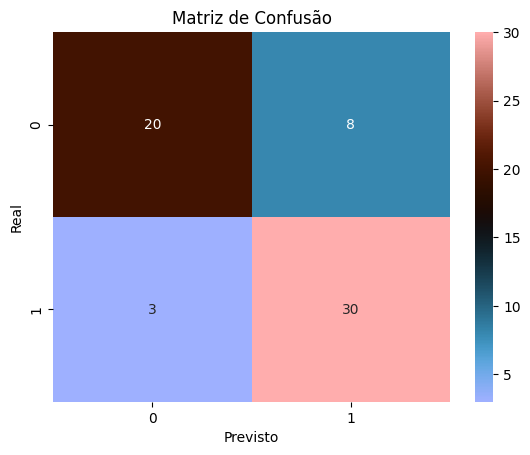

In [108]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='berlin')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, heart_atck_proba)
roc_auc = roc_auc_score(y_test, heart_atck_proba)

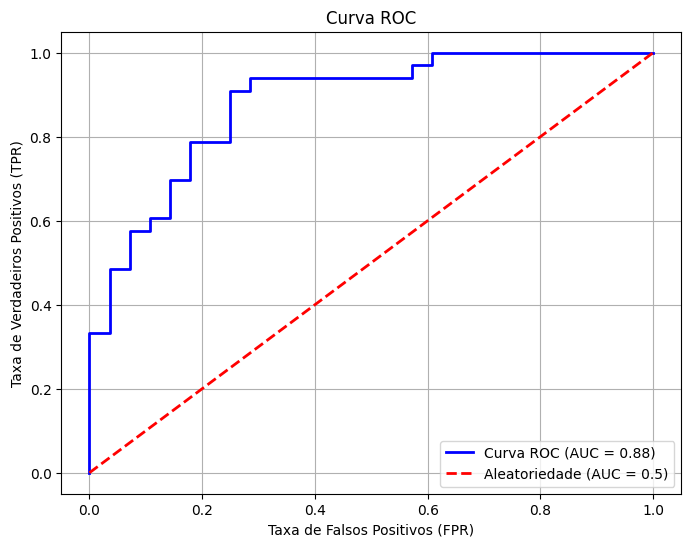

In [110]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Aleatoriedade (AUC = 0.5)')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [111]:
p, r, _ = precision_recall_curve(y_test, heart_atck_proba)
pr_auc = auc(r, p)

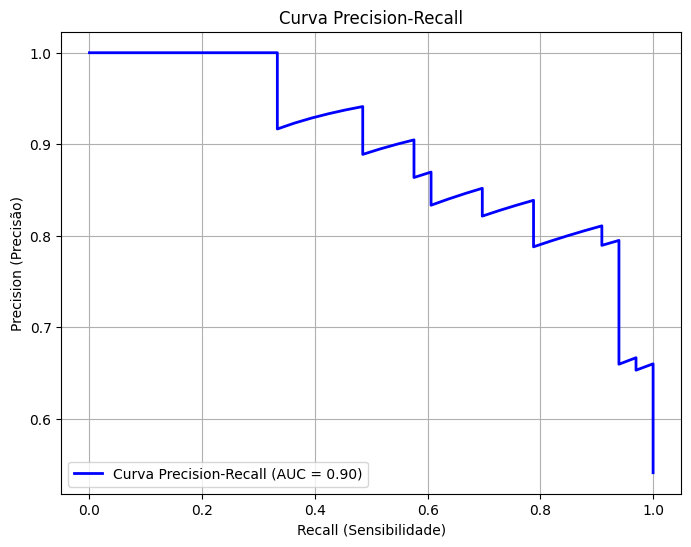

In [112]:
plt.figure(figsize=(8, 6))
plt.plot(r, p, color='blue', lw=2, label=f'Curva Precision-Recall (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()